# Reducers

## Experiment
The goal of the second experiment is to find the best number of composites in conjunction with the best temporal reducers that are beneficial in predicting leaf type mixture as a regression problem. The experiment assumes the following:

- A time window of 1 year is chosen, starting with 1. April, 2017, thus covering all seasons. April of 2017 was the first whole month with Level-2A imagery and the closest to the recording dates.
- Level-2A Sentinel 2 satellite imagery and indices determined by the previous experiment are used as input features.
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

The experiment is conducted on 1 to 12 composites in 1 step intervals with the following temporal reducers:

In [1]:
# List the available reducers (except for reducers with a NonNull variant)
from ltm.data import list_reducers

reducers = list_reducers()
reducers = [reducer for reducer in reducers if not reducer + "NonNull" in reducers]

reducers

['And',
 'Or',
 'allNonZero',
 'anyNonZero',
 'bitwiseAnd',
 'bitwiseOr',
 'circularMean',
 'circularStddev',
 'circularVariance',
 'count',
 'countDistinctNonNull',
 'countRuns',
 'firstNonNull',
 'kendallsCorrelation',
 'kurtosis',
 'lastNonNull',
 'max',
 'mean',
 'median',
 'min',
 'minMax',
 'mode',
 'product',
 'sampleStdDev',
 'sampleVariance',
 'skew',
 'stdDev',
 'sum',
 'variance']

Following Sentinel 2 bands and indices determined in the previous experiment are used as input features:

In [2]:
# List the bands determined by the previous experiment
from ltm.models import bands_from_importance

sentinel_bands, indices = bands_from_importance("../reports/band_importance.csv")

sentinel_bands, indices

Initializing Earth Engine API...


(['B9', 'WVP', 'TCI_G'],
 ['BAIM',
  'BWDRVI',
  'GCC',
  'MCARI705',
  'MIRBI',
  'MLSWI26',
  'MNLI',
  'MTCI',
  'MuWIR',
  'NBRplus',
  'NDDI',
  'NDGI',
  'NSDSI1',
  'NormR',
  'RGRI',
  'S2WI',
  'SIPI',
  'TRRVI',
  'TTVI',
  'VI700',
  'VIBI',
  'WI2',
  'WI2015',
  'kEVI',
  'kIPVI',
  'kNDVI',
  'mSR705'])

In [3]:
from datetime import datetime
from itertools import product
from ltm.data import sentinel_composite
from ltm.features import (
    load_raster,
    interpolate_data,
    to_float32,
)
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from time import sleep
from tqdm.notebook import tqdm

model = RandomForestRegressor(n_jobs=-1, random_state=42)
search_space = {
    "time_window": [(datetime(2017, 4, 1), datetime(2018, 4, 1))],
    "num_composites": list(range(1, 13))[::-1],  # Reverse to start with slowest
    "temporal_reducers": [[reducer] for reducer in reducers],
    "indices": [indices],
    "sentinel_bands": [sentinel_bands],
}
scoring = {"Root Mean Squared Error": make_scorer(root_mean_squared_error)}
target_path = "../data/processed/target.tif"


def create_data(target_path, search_point):
    # Create data_path and ensure directory exists
    reducer = search_point["temporal_reducers"][0]
    composites = search_point["num_composites"]
    data_path_to = (
        f"../data/processed/reducer_composites/data_{reducer}_{composites}.tif"
    )
    Path(data_path_to).parent.mkdir(parents=True, exist_ok=True)

    # Create the composite (retrying if it fails)
    batch_size = None
    while not Path(data_path_to).exists():
        try:
            sentinel_composite(
                target_path_from=target_path,
                data_path_to=data_path_to,
                batch_size=batch_size,
                **search_point,
            )
        except:
            if batch_size is not None:
                if batch_size < 256:
                    sleep_time = 100 * 256 / batch_size
                    print(f"Sleeping for {sleep_time} seconds")
                    sleep(sleep_time)

                batch_size /= 2
            else:
                batch_size = 512

            print(f"Retrying with batch_size={batch_size}")

    # Fill missing values by linear (circular) interpolation
    data = load_raster(data_path_to)
    interpolated_data = interpolate_data(data)
    interpolated_data = to_float32(interpolated_data)

    return interpolated_data


def check_row_exists(search_point):
    try:
        df = pd.read_csv("../reports/reducer_composites.csv")
        for i, row in df.iterrows():
            if list(row[:2]) == [
                search_point["temporal_reducers"][0],
                search_point["num_composites"],
            ]:
                return True

        return False
    except FileNotFoundError:
        return False


def callback(scores, scoring, search_point):
    # Read the reducer_composites.csv
    reducer_composites = "../reports/reducer_composites.csv"
    try:
        df = pd.read_csv(reducer_composites)
    except FileNotFoundError:
        columns = ["Reducer", "Composites"] + list(scoring.keys())
        df = pd.DataFrame(columns=columns)

    # Store the scores in the dataframe
    first_columns = [
        search_point["temporal_reducers"][0],
        search_point["num_composites"],
    ]
    last_columns = [scores[f"test_{key}"].mean() for key in scoring.keys()]
    idx = len(df)
    for i, row in df.iterrows():
        if list(row[:2]) == first_columns:
            idx = i
    df.loc[idx] = first_columns + last_columns

    # Save to CSV
    df.to_csv(reducer_composites, index=False)


def grid_search(
    model,
    search_space,
    scoring,
    target_path,
    create_data=create_data,
    callback=callback,
):
    target = load_raster(target_path)

    params = search_space.keys()
    for values in tqdm(list(product(*search_space.values()))):
        search_point = dict(zip(params, values))

        # Skip if the row already exists
        if check_row_exists(search_point):
            continue

        data = create_data(target_path, search_point)
        data_no_nan, target_no_nan = (
            data[target.notna()],
            target[target.notna()],
        )

        if len(data_no_nan) < 5:
            scores = {f"test_{key}": np.full(1, np.nan) for key in scoring.keys()}
        else:
            scores = cross_validate(
                model, data_no_nan, target_no_nan, scoring=scoring, n_jobs=-1
            )
        callback(scores, scoring, search_point)


grid_search(model, search_space, scoring, target_path)

  0%|          | 0/348 [00:00<?, ?it/s]

In [4]:
# Use science style
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

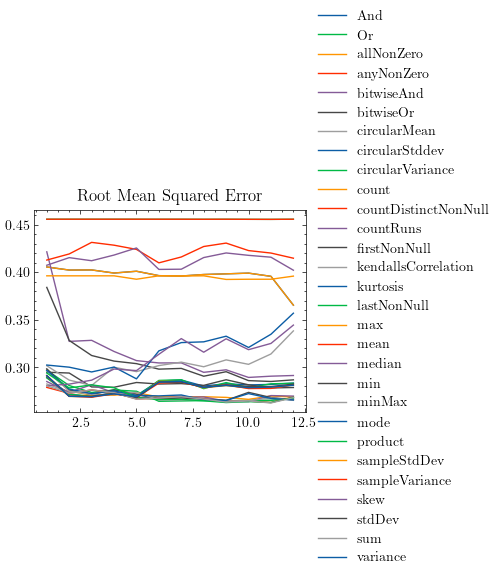

In [5]:
# TODO: improve plot
# Draw one multiline plot per metric with all gray lines except for the 5 best reducers
import pandas as pd

df = pd.read_csv("../reports/reducer_composites.csv")

dfs = {}
for i, (metric, scorer) in enumerate(scoring.items()):
    new_df = pd.DataFrame(index=df["Composites"].unique()[::-1])

    grouped = df[["Reducer", "Composites", metric]].groupby("Reducer")
    for name, group in grouped:
        group = group.sort_values("Composites")
        new_df[name] = np.asarray(group[metric])

    dfs[metric] = new_df

# fig, axes = plt.subplots(len(scoring), 1, figsize=(5, 5*len(scoring)))
ax = plt.subplot()

metric = list(dfs.keys())[0]
dfs[metric].plot(ax=ax, title=metric, legend=False)

golden_ratio = (1 + 5**0.5) / 2
ax.legend(loc="center left", bbox_to_anchor=(1, 1 / golden_ratio))

In [6]:
# Best RMSE for the target without any information
from sklearn.dummy import DummyRegressor
from ltm.features import load_raster
from sklearn.metrics import make_scorer, root_mean_squared_error

target = load_raster(target_path)
target = target[target.notna()]
data = np.zeros_like(target).reshape(-1, 1)
scorer = make_scorer(root_mean_squared_error)

dummy = DummyRegressor(strategy="mean")
cv_result = cross_validate(dummy, data, target, scoring=scorer, n_jobs=-1)
dummy_score = cv_result["test_score"].mean()
dummy_score

0.45560590764009135

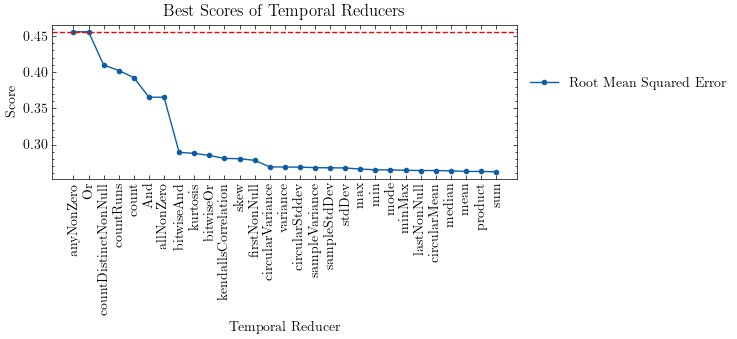

In [7]:
from ltm.visualize import plot_report

plt_df = pd.DataFrame({"Root Mean Squared Error": dfs["Root Mean Squared Error"].min()})

ax = plot_report(
    plt_df.sort_values("Root Mean Squared Error", ascending=False),
    "Best Scores of Temporal Reducers",
    "Temporal Reducer",
    "Score",
    label_rotation=90,
    figsize=(6, 2),
    marker=".",
)

ax.axhline(y=dummy_score, color="red", linestyle="--")

plt.show()

# Interpretation of the Results

We decide to discard following reducers:
- quantitative and logical reducers that only consider the presence/absence of images, but not the actual values of the pixels, which are
- all variance and stdDev reducers, with the exception of sampleVariance. They all correlate highly, circular does not make much sense as the data is not in radians, without "sample" prefix, it is not as accurate for small sample sizes. Variance performed better than stdDev in most cases.
- firstNonNull and lastNonNull reducers, which are highly dependent on the weather conditions on the first and last image respectively.
- circular reducers, which are not applicable to the bands of the Sentinel-2 satellite imagery, as the intensities are not radians angles.
- kendallsCorrelation as it is NaN
- statistical reducers for population statistics, where a sample version exists
- "sum" is highly correlated with "mean"
- "product" is, like "sum", sensitively depend on the number of available images for a composite
- MinMax as it combines min and max, which are already present as reducers

In [ ]:
# Define all reducers that come into question
reducers = [
    "median",
    "mean",
    "mode",
    "min",
    "max",
    "sampleVariance",
    "kendallsCorrelation",
    "skew",
    "kurtosis",
]

In [ ]:
# Find the best number of composites for each reducer
best_composites = pd.DataFrame()

metric = list(scoring.keys())[0]
best_composites["Smallest Number of Composites"] = dfs[metric][reducers].idxmin()

best_composites

In [ ]:
from ltm.features import save_raster

total_data_path = "../data/processed/data.tif"

if not Path(total_data_path).exists():
    total_data = pd.DataFrame()

    for reducer in tqdm(best_composites.index):
        num_composites = best_composites.loc[reducer, "Smallest Number of Composites"]
        data_path = (
            f"../data/processed/reducer_composites/data_{reducer}_{num_composites}.tif"
        )
        Path(data_path).parent.mkdir(parents=True, exist_ok=True)

        if not Path(data_path).exists():
            sentinel_composite(
                target_path_from=target_path,
                data_path_to=data_path,
                time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
                temporal_reducers=[reducer],
                num_composites=int(num_composites),
                indices=indices,
                sentinel_bands=sentinel_bands,
            )

        data = load_raster(data_path)
        data = interpolate_data(data)
        data = to_float32(data)
        total_data = pd.concat([total_data, data], axis=1)

    save_raster(total_data, "../data/processed/target.tif", total_data_path)
else:
    total_data = load_raster(total_data_path)

In [ ]:
# Cross validate the new data
total_data = load_raster("../data/processed/data.tif")
target = load_raster(target_path)
total_data, target = total_data[target.notna()], target[target.notna()]

model = RandomForestRegressor(n_jobs=-1, random_state=42)
scores = cross_validate(model, total_data, target, scoring=scoring, n_jobs=-1)

# Compute the means per metric
means = {f"test_{key}": scores[f"test_{key}"].mean() for key in scoring.keys()}
means